<a href="https://colab.research.google.com/github/noobmaster-ru/numerical_methods_6sem/blob/main/numerical_methods_task_3_kozlov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.hd
Версия на ТРОЙКУ!

17 мая 17:20 -  порядок аппроксимации 2 на неравномерных и равномерных сетках при гладких коэфициентах p,f,q == 1.0 , на гладких тоже ок, главное чтобы они в ноль не обращались

# Вычисление

## Импорт библиотек

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import math
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d
import time
from itertools import product

## Задание c1,c2,c3,c4

In [52]:
'''
Параметры сетки(чем больше,тем сильнее сгущение):
   •	c1 > 0: сгущение к левому краю отрезка
   •	c3 < 0: сгущение к правому краю
   •	c2 = 0: равномерно
'''
# при |c_module| >= 7.7 порядок аппроксимации близок к 2 , ~ 1.8-2.0
c_module = 3.0

# (+) <----
# (-) ---->
c1 = -c_module
c2 = c_module

c3 = -c_module
c4 = c_module

# N - количество узлов на каждом отрезке(то есть всего будет 4*N узлов)
N = 20

# Эпсилон окрестность для приближенного графика решения
eps = 0.25


## Генерация сетки

In [53]:
def phi(t, alpha, beta, c):
    """Монотонная трансформация t ∈ [0,1] в [alpha, beta] с экспоненциальным сгущением"""
    if c == 0:
        return alpha + (beta - alpha) * t  # равномерный случай
    return alpha + (beta - alpha) * (np.exp(c * t) - 1) / (np.exp(c) - 1)

def generate_segment(alpha, beta, N, c):
    """Генерация сетки на отрезке [alpha, beta] с N интервалами, используя phi"""
    t = np.linspace(0, 1, N+1 ) # N + 1 было
    return phi(t, alpha, beta, c)


In [54]:
# Создание неравномерной сетки
def generate_grid(N, c1, c2, c3, c4):
    """
    Генерация неравномерной сетки на [0, pi], разбитой на 3 части:
    [0, pi/3], [pi/3, 2pi/3], [2pi/3, pi], каждая с экспоненциальной трансформацией
    Параметры:
      •	c1 > 0: сгущение к левому краю отрезка
      •	c3 < 0: сгущение к правому краю
      •	c2 = 0: равномерно
    """
    # Делаем 4 отрезка: [0, pi/3),[pi/3, pi/2),[pi/2, 2pi/3),[2pi/3, pi]

    # сделаем 3 отрезка:  неравномерный [0, pi/3) , равномерный [pi/3,2pi/3), снова неравномерный [2pi/3, pi]
    x0 = 0
    x1 = np.pi / 3
    x2 = (2 * np.pi / 3 + np.pi / 3)/2 # == pi/2
    x3 = 2 * np.pi / 3
    x4 = np.pi


    grid1 = generate_segment(x0, x1, N, c1)[:-1]  # [0, pi/3)
    grid2 = generate_segment(x1, x2, N, c2)[:-1]  # [pi/3, pi/2)
    grid3 = generate_segment(x2, x3, N, c3)[:-1]  # [pi/2, 2pi/3)
    grid4 = generate_segment(x3, x4, N, c4)   # [2pi/3, pi]

    x = np.concatenate([grid1, grid2, grid3, grid4])
    return x

In [55]:
x = generate_grid(N,c1,c2,c3,c4)

## Задание p, q ,f

In [56]:
def f_pi_2(x_i):
  index_of_pi_2 = np.where(x == x_i)[0][0] # первый индекс элемента с значением pi/2

  # ищем значения x_(i+1/2) и x_(i-1/2)
  x_i_minus_1_2 = (x[index_of_pi_2] + x[index_of_pi_2 - 1])/2
  x_i_plus_1_2 = (x[index_of_pi_2] + x[index_of_pi_2 + 1])/2

  return np.cos(x_i_minus_1_2) + x_i_plus_1_2 - np.cos(x_i_plus_1_2) - x_i

In [57]:
def p_2pi_3(x_i):
  index_of_2pi_3 = np.where(x == x_i)[0][0] # первый индекс элемента с значением 2pi/3

  # ищем значения x_(i+1/2) и x_(i-1/2)
  x_i_minus_1_2 = (x[index_of_2pi_3] + x[index_of_2pi_3 - 1])/2
  x_i_plus_1_2 = (x[index_of_2pi_3] + x[index_of_2pi_3 + 1])/2


  return (-(x_i_minus_1_2**3)/3 + 0.1*x_i_plus_1_2 - 0.1*x_i + (x_i_plus_1_2**3)/3
  - np.pi*(x_i_plus_1_2**2) + np.pi*(x_i**2) + (np.pi**2)*x_i_plus_1_2 - (np.pi**2)*x_i)

In [58]:
# Задание коэффициентов
# в точках разрыва надо посчитать интеграл от x_i-1/2 до x_i+1/2(p(x))
def p(x_i):
  return 1.0
  # if (0 <= x_i <= np.pi / 3):
  #     return (x_i - np.pi / 2) ** 2
  # elif (np.pi / 3) < x_i < (2 * np.pi / 3):
  #     return x_i ** 2
  # elif (x_i == 2 * np.pi / 3):
  #     return p_2pi_3(x_i)
  # else: # elif (2 * np.pi / 3) < x_i < (np.pi):
  #     return 0.1 + (x_i - np.pi) ** 2
def q(x_i):
    return 1.0
def f(x_i):
  return 1.0
  # if 0 <= x_i < np.pi / 2:
  #     return np.sin(x_i)
  # elif x_i == np.pi /2:
  #   return f_pi_2(x_i)
  # else:
  #     return 1 + np.sin(x_i)

## Задание g0, g1, beta0 , beta1

In [59]:
g0 = 0.0
g1 = 1.0
beta_0 = 1.0
beta_1 = 1.0

## Построение графиков

In [60]:
def plot_grid(x):
    plt.figure(figsize=(16, 2.0))
    plt.eventplot(x, orientation='horizontal', colors='blue', linewidth=1.2)

    # Вертикальные линии разрыва
    plt.axvline(np.pi/3, color='red', linestyle='--',dashes=(1, 1), linewidth=1.2, label=r'$\frac{\pi}{3}$')
    plt.axvline(2*np.pi/3, color='green', linestyle='--',dashes=(1, 1), linewidth=1.2, label=r'$\frac{2\pi}{3}$')


    # Настройка xticks
    tick_positions = [0, np.pi/3, np.pi/2, 2*np.pi/3, np.pi]
    tick_labels = [r'$0$', r'$\frac{\pi}{3}$',r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$', r'$\pi$']
    plt.xticks(tick_positions, tick_labels, fontsize=15)


    # Остальные настройки
    plt.title("Неравномерная сетка с экспоненциальным сгущением с узлами в точках разрыва", fontsize=20)
    plt.yticks([])
    plt.xlabel("Ось Ox",  fontweight='bold', fontsize=15)
    plt.grid(True, axis='x', linestyle=':', alpha=0.9)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.35)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=15)

    plt.tight_layout()
    plt.show()
    print("\n")

In [61]:
def plot_solution(x,u,u_true, equal_grid):
    fig = plt.figure(figsize=(16, 8))
    plt.plot(x, u, label=f"u(x), N = {len(x)} узлов", color="blue", linewidth=4)
    plt.plot(x, u_true, linestyle='--', label="Истинное решение scipy.linalg.solve",color="red",linewidth=4)
    # plt.plot(x, u, 'o', color='black', markersize=4,alpha=1.0)

    # Добавим вертикальные линии в точках разрыва
    plt.axvline(np.pi/3, color='navy', linestyle='--', linewidth=1.0)
    plt.axvline(2*np.pi/3, color='green', linestyle='--', linewidth=1.0)

    # Добавим маркеры в этих точках, если они присутствуют в сетке x - eps
    for xi, color in [(np.pi/3, 'navy'), (2*np.pi/3, 'green'), (x[0], 'black'),(x[-1], 'black')]:
        idx = np.argmin(np.abs(x - xi))
        plt.plot(x[idx], u[idx], 'o', color=color, markersize=7, label=fr'$u(\frac{{{int(round(xi/np.pi*3))}\pi}}{{3}})$')

    # Оформление осей
    plt.xlabel("Ось x", labelpad=10, fontsize=20, fontweight='bold')
    plt.ylabel("u(x)", rotation=0, labelpad=10, fontsize=20, fontweight='bold')
    if equal_grid:
      plt.title("Численное решение краевой задачи(равномерная сетка)", fontsize=20)
      for i in range(len(x)):
        plt.axvline(x[i], color='black', linestyle='--', linewidth=0.5)
    else:
      plt.title("Численное решение краевой задачи(неравномерная сетка)", fontsize=20)


    # Подписи оси X
    tick_positions = [0, np.pi/3, 2*np.pi/3, np.pi]
    tick_labels = [r'$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$']
    plt.xticks(tick_positions, tick_labels, fontsize=15)

    # Сетка
    plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

    # Легенда
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()
    print("\n")

In [62]:
def zoom_around_discontinuity(x, u, x0, eps, point):
    """
    Визуализация решения на участке [x0 - eps, x0 + eps]
    """
    # Подсчёт количества узлов в подотрезке
    x_left = x0 - eps
    x_right = x0 + eps
    mask = (x >= x_left) & (x <= x_right)
    num_nodes_in_segment = np.sum(mask)
    mask = (x >= x0 - eps) & (x <= x0 + eps)
    x_zoom = x[mask]
    u_zoom = u[mask]

    plt.figure(figsize=(10, 6))
    plt.plot(x_zoom, u_zoom, '-',color='blue', linewidth=2, label=f"u(x), N = {num_nodes_in_segment} узлов")


    if point =="pi/3":
      label = r'Узлы в $[\frac{\pi}{3} - \varepsilon, \frac{\pi}{3} + \varepsilon]$, ' + fr'$\varepsilon = {eps}$'
      plt.plot(x_zoom, u_zoom, 'o', color='black', markersize=6, label=label,alpha=1.0)

      # Вертикальная линия в точке разрыва
      plt.axvline(x0, color='red', linestyle='--', linewidth=1.2, label=r'$x = \frac{\pi}{3}$')
      plt.title(r"Приближение к точке разрыва $x = \frac{\pi}{3}$", fontsize=15)
      plt.xlabel("Ось x", fontweight='bold', fontsize=15)
      plt.ylabel("u(x)",rotation=0, fontweight='bold', fontsize=15)

      # Подписи оси X
      tick_positions = [x_left,x0, x_right]
      tick_labels = [r'$\frac{\pi}{3}-\varepsilon$',r'$\frac{\pi}{3}$',r'$\frac{\pi}{3}+\varepsilon$']
      plt.xticks(tick_positions, tick_labels, fontsize=15)

      # Сетка
      plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
      plt.minorticks_on()
      plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

      plt.legend()
      plt.tight_layout()
      plt.show()
      print("\n")
    else:
      label = r'Узлы в $[\frac{2\pi}{3} - \varepsilon, \frac{2\pi}{3} + \varepsilon]$, ' + fr'$\varepsilon = {eps}$'

      plt.plot(x_zoom, u_zoom, 'o', color='black', markersize=6, label=label,alpha=1.0)

      # Вертикальная линия в точке разрыва
      plt.axvline(x0, color='green', linestyle='--', linewidth=1.2, label=r'$x = \frac{2\pi}{3}$')
      plt.title(r"Приближение к точке разрыва $x = \frac{2\pi}{3}$", fontsize=15)
      plt.xlabel("Ось x", fontweight='bold', fontsize=15)
      plt.ylabel("u(x)",rotation=0, fontweight='bold', fontsize=15)

      # Подписи оси X
      tick_positions = [x_left,x0, x_right]
      tick_labels = [r'$\frac{2\pi}{3}-\varepsilon$',r'$\frac{2\pi}{3}$',r'$\frac{2\pi}{3}+\varepsilon$']
      plt.xticks(tick_positions, tick_labels, fontsize=15)

      # Сетка
      plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
      plt.minorticks_on()
      plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

      plt.legend()
      plt.tight_layout()
      plt.show()
      print("\n")

## Схема

In [63]:
def build_matrix_and_rhs(x):
    N = len(x)-1

    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)

    # здесь всё ок
    # Левое граничное условие (второй порядок должен быть)
    A[0, 0] = 1.0
    A[0, 1] = 0.0
    b[0] = g0

    # здесь всё ок
    # Внутренние узлы (второй порядок)
    for i in range(1, N):
        h_i_minus_1 = x[i] - x[i-1]
        h_i = x[i+1] - x[i]

        p_i_minus_1 = p((x[i] + x[i-1]) / 2)
        p_i_plus_1 = p((x[i+1] + x[i]) / 2)

        A[i, i-1] = -p_i_minus_1 / h_i_minus_1
        A[i, i] = (p_i_minus_1 / h_i_minus_1) + (p_i_plus_1 / h_i) + q(x[i]) * (h_i_minus_1 + h_i) / 2
        A[i, i+1] = -p_i_plus_1 / h_i
        b[i] = f(x[i]) * (h_i_minus_1 + h_i) / 2


    # вроде заменил
    # Правое граничное условие ( второй порядок должен быть)
    h = x[-1] - x[-2]

    p_N_minus_1_del_2 = p((x[-1] + x[-2])/2)
    p_N_minus_1 = p(x[-2])
    q_N_minus_1 = q(x[-2])
    f_N_minus_1 = f(x[-2])
    p_L = p(np.pi)
    A[N, N-1] = (p_N_minus_1_del_2 / h) - (p_N_minus_1 * beta_1) + (h / 2)*q_N_minus_1
    A[N, N] = - (p_N_minus_1_del_2 / h)
    b[N] = f_N_minus_1 * (h / 2) - (p_N_minus_1/p_L)*g1


    return A, b

## Решения СЛАУ

In [64]:
def is_tridiagonal(A):
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            if abs(i - j) > 1 and abs(A[i,j]) > 1e-10:
                return False
    return True

In [65]:
def progonka(A, b):
    n = len(b)
    a = np.zeros(n)
    c = np.zeros(n)
    diag = np.zeros(n)


    for i in range(n):
        diag[i] = A[i, i]
        if i > 0:
            a[i] = A[i, i - 1]
        if i < n - 1:
            c[i] = A[i, i + 1]

    # Прямая прогонка
    alpha = np.zeros(n)
    beta = np.zeros(n)

    alpha[0] = -c[0] / diag[0]
    beta[0] = b[0] / diag[0]

    for i in range(1, n):
        denom = a[i] * alpha[i - 1] + diag[i]
        if i < n - 1:
            alpha[i] = -c[i] / denom
        beta[i] = (b[i] - a[i] * beta[i - 1]) / denom

    # Обратная прогонка
    x = np.zeros(n)
    x[-1] = beta[-1]
    for i in reversed(range(n - 1)):
        x[i] = alpha[i] * x[i + 1] + beta[i]

    return x

## main


In [66]:
# Основной расчет
A, b = build_matrix_and_rhs(x)
if not is_tridiagonal(A):
    print("Предупреждение: матрица не строго трёхдиагональная!")
u = progonka(A,b)
u_true = solve(A, b)

## Визуализация

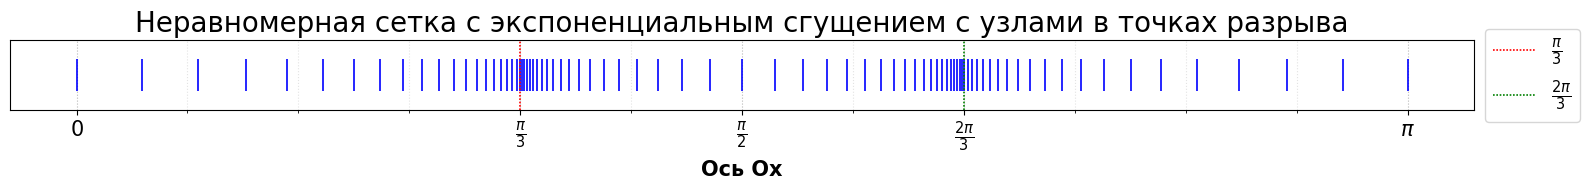

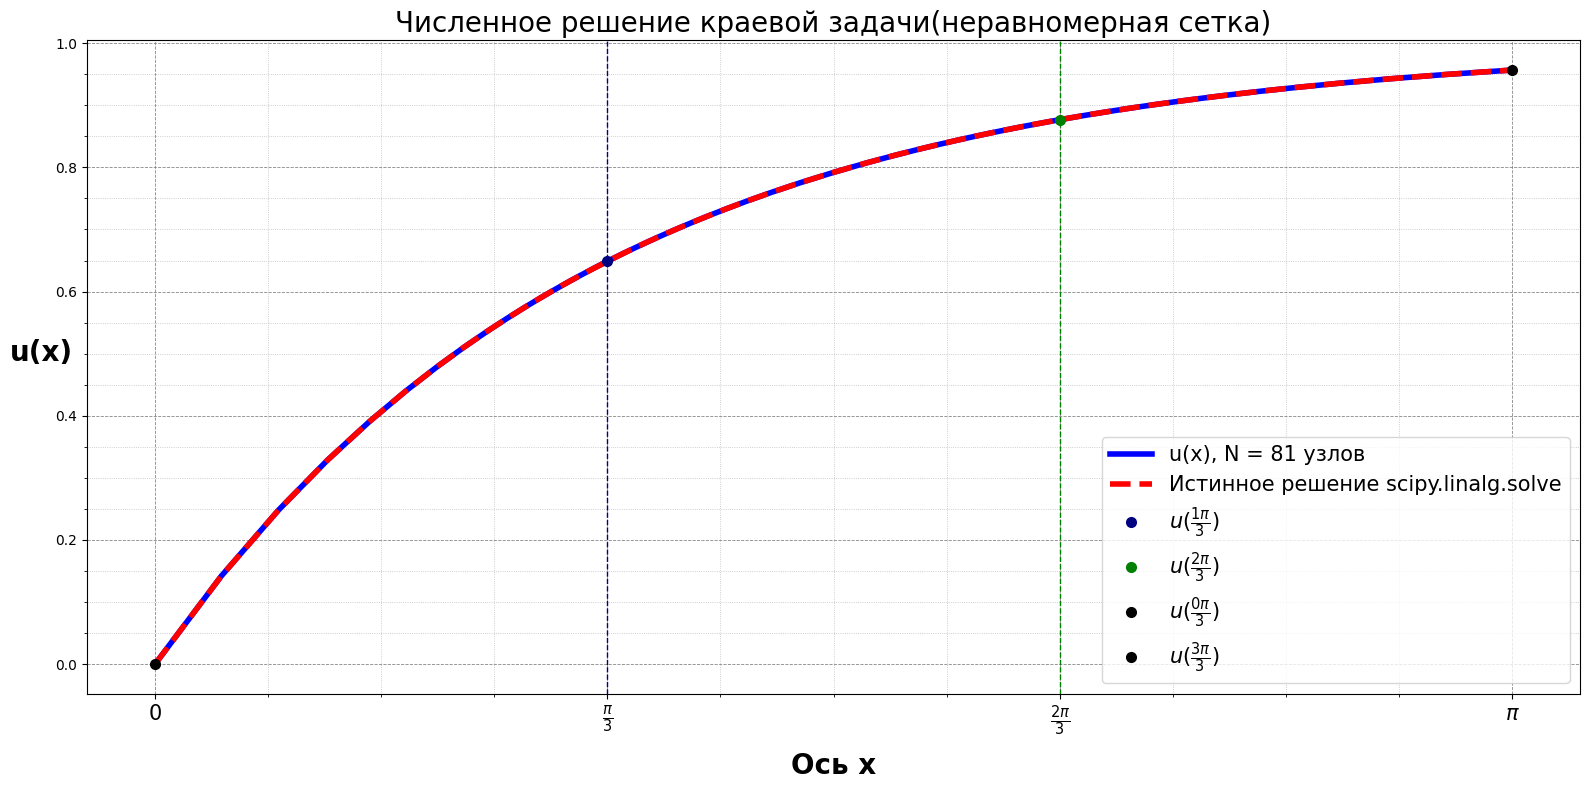

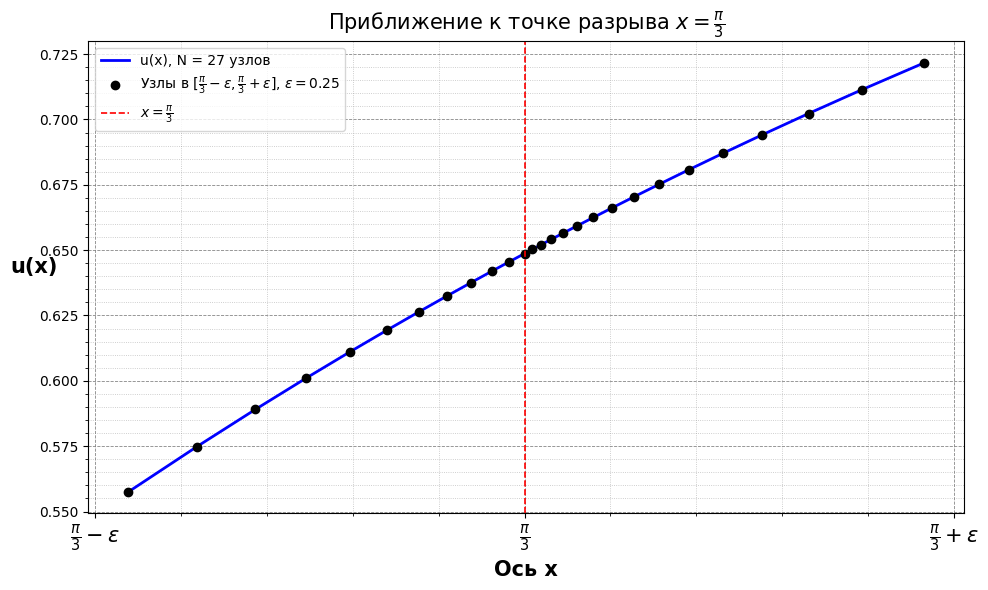

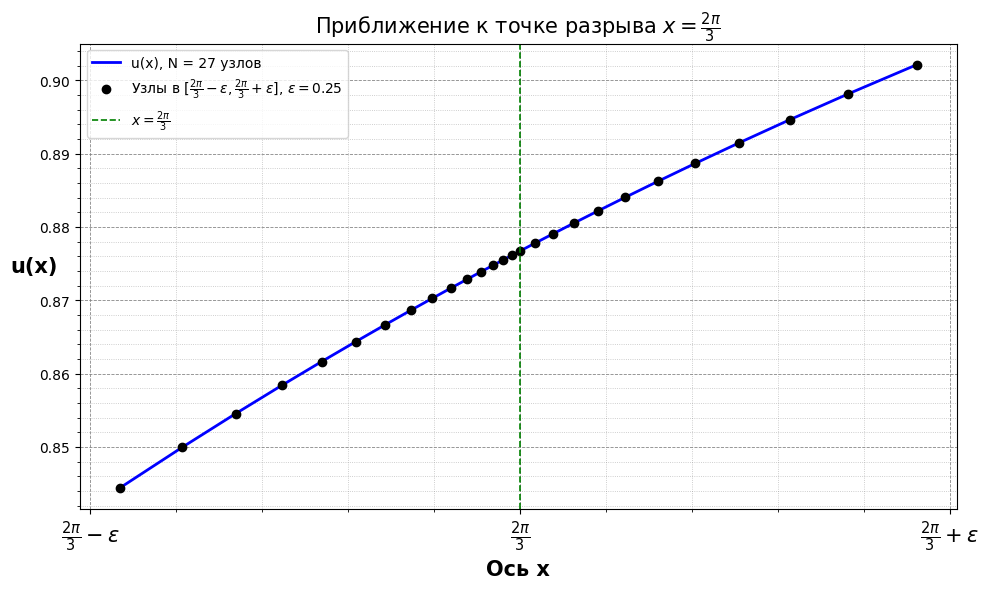

In [67]:
plot_grid(x) # Сетка
plot_solution(x,u,u_true,False) # Решение

# Приближение решения в окрестноти точек разрыва
zoom_around_discontinuity(x, u, np.pi/3, eps, "pi/3")
zoom_around_discontinuity(x, u, 2*np.pi/3, eps, "2pi/3")


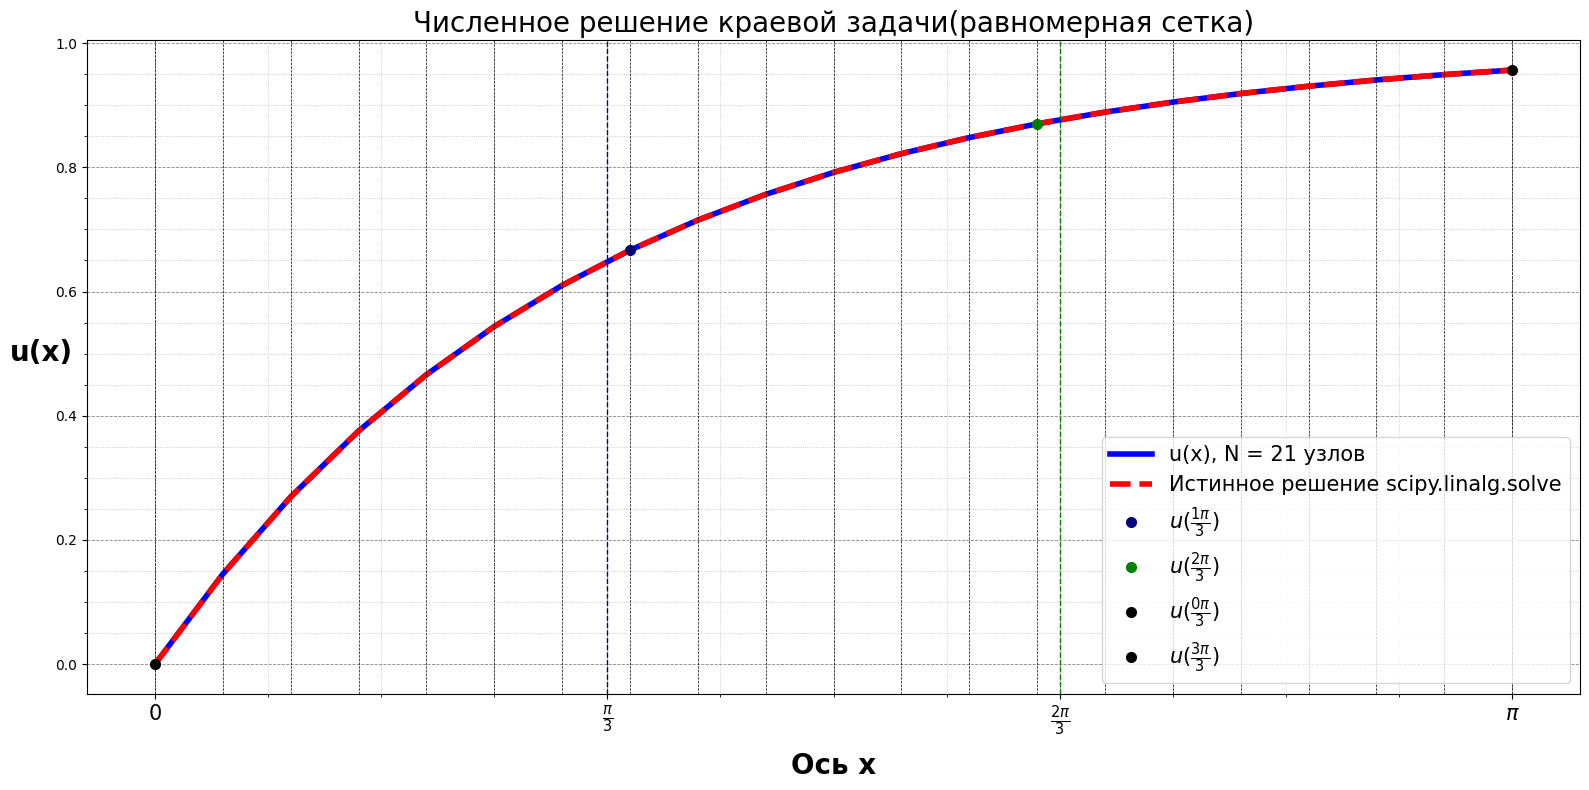

In [68]:
# Решение на равномерной сетке
x = np.linspace(0, np.pi, N + 1)
A, b = build_matrix_and_rhs(x)
u = progonka(A,b)
u_true = solve(A, b)
plot_solution(x,u,u_true,True) # Решение

# Оценка сходимости методом Рунге

In [69]:
def max_norm_error(x_one, u_one, x_two, u_two):
  length = len(x_one)
  max_err = 0.0
  for i in range(length-1):
    err = abs(u_one[i] - u_two[i*2])
    if err > max_err:
      max_err = err
  err = abs(u_one[-1] - u_two[-1])
  if err > max_err:
    max_err = err
  return  max_err

In [70]:
# Численный расчет для метода Рунге
def numerical_solution(N, equal_grid):
  if equal_grid:
    x = np.linspace(0, np.pi, N +1) #  N + 1 было
  else:
    x = generate_grid(N,c1,c2,c3,c4)
  A, b = build_matrix_and_rhs(x)
  u = progonka(A,b)
  return x, u

In [71]:
# Метод Рунге для оценки порядка (неравномерные сетки)
def runge_convergence_v1(N_coarse, equal_grid ,r = 2):
  x_n, u_n = numerical_solution(N_coarse, equal_grid)
  x_2n, u_2n = numerical_solution(N_coarse * r, equal_grid)
  x_4n, u_4n = numerical_solution(N_coarse * r * r, equal_grid)

  norm_up = max_norm_error(x_n,u_n,x_2n,u_2n)
  norm_low = max_norm_error(x_2n,u_2n,x_4n,u_4n)
  rate = np.log2(norm_up / norm_low)

  return  rate

## Метод Рунге

In [72]:
Ns = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800]

In [73]:
print(f"     Метод Рунге (неравномерные сетки)")
print(f"c1 = {c1}, c2 = {c2}, c3 = {c3}, c4 = {c4}\n")
for Number in Ns:
  rate = runge_convergence_v1(Number, equal_grid=False)
  print(f"N={Number}: порядок аппроксимации p ≈ {rate:.4f}")


     Метод Рунге (неравномерные сетки)
c1 = -3.0, c2 = 3.0, c3 = -3.0, c4 = 3.0

N=10: порядок аппроксимации p ≈ 1.9333
N=20: порядок аппроксимации p ≈ 1.9834
N=30: порядок аппроксимации p ≈ 1.9929
N=40: порядок аппроксимации p ≈ 1.9962
N=50: порядок аппроксимации p ≈ 1.9977
N=60: порядок аппроксимации p ≈ 1.9985
N=70: порядок аппроксимации p ≈ 1.9989
N=80: порядок аппроксимации p ≈ 1.9992
N=90: порядок аппроксимации p ≈ 1.9994
N=100: порядок аппроксимации p ≈ 1.9996
N=200: порядок аппроксимации p ≈ 2.0000
N=300: порядок аппроксимации p ≈ 2.0000
N=400: порядок аппроксимации p ≈ 1.9999
N=500: порядок аппроксимации p ≈ 1.9998
N=600: порядок аппроксимации p ≈ 1.9998
N=700: порядок аппроксимации p ≈ 2.0004
N=800: порядок аппроксимации p ≈ 1.9998


In [74]:
print(f"     Метод Рунге (равномерные сетки)")
print(f"c1 = {c1}, c2 = {c2}, c3 = {c3}, c4 = {c4}\n")
for Number in Ns:
  rate = runge_convergence_v1(Number,equal_grid=True)
  print(f"N={Number}: порядок аппроксимации p ≈ {rate:.4f}")

     Метод Рунге (равномерные сетки)
c1 = -3.0, c2 = 3.0, c3 = -3.0, c4 = 3.0

N=10: порядок аппроксимации p ≈ 1.9989
N=20: порядок аппроксимации p ≈ 2.0010
N=30: порядок аппроксимации p ≈ 2.0026
N=40: порядок аппроксимации p ≈ 2.0020
N=50: порядок аппроксимации p ≈ 2.0014
N=60: порядок аппроксимации p ≈ 2.0012
N=70: порядок аппроксимации p ≈ 2.0012
N=80: порядок аппроксимации p ≈ 2.0011
N=90: порядок аппроксимации p ≈ 2.0009
N=100: порядок аппроксимации p ≈ 2.0008
N=200: порядок аппроксимации p ≈ 2.0005
N=300: порядок аппроксимации p ≈ 2.0003
N=400: порядок аппроксимации p ≈ 2.0003
N=500: порядок аппроксимации p ≈ 2.0002
N=600: порядок аппроксимации p ≈ 2.0009
N=700: порядок аппроксимации p ≈ 1.9995
N=800: порядок аппроксимации p ≈ 1.9986


## Поиск c_i

In [75]:
#  ищем параметры c_i для сетки чтобы был порядок аппроксимации равен 2
# step = 0.1
# epsilon = 0.2
# print("N, c_module, rate_equal_grid , rate_unequal_grid")
# for N in range(20,100,5):
#   c_module = 0.0
#   for i in range(200):
#     c_module += step

#     c1 = c_module  # (+) <---  влево плюс
#     c2 = c_module # (-) ---> вправо минус
#     c3 = c_module
#     c4 = c_module

#     rate_equal_grid = runge_convergence_v1(N,True)
#     rate_unequal_grid = runge_convergence_v1(N,False)
#     if (abs(rate_equal_grid - 2.0) <= epsilon) and (abs(rate_unequal_grid - 2.0) <= epsilon):
#       print(c_module)

# Итого

При всех f,q,p = 1.0 порядок аппроксимации равен 2 при равномерных и неравномерных сетках.

Если изменить f,q,p на разрывные, то при неравномерных сетках порядок примерно равен 2, а при равномерных нет: от 1.8 до 1.0